In [10]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
mpl.rcParams["figure.dpi"] = 100
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset

from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
import networkx as nx


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
directory_targ = r"C:\Users\coren\Documents\temp_441/"


In [12]:
plate_id = "441_20230807"

In [13]:
update_plate_info(directory_targ, local=True,strong_constraint=False)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled2.p"] == True]
folders = folders.sort_values(by="folder")

analysed:   0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
plate_id_video = "20230811_Plate441"
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
i = 0
exp.load(folders.iloc[i : i + 2], suffix="_labeled2")
# exp.load(selection, suffix="_labeled")

for t in range(exp.ts):
    print(t)
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)

# load_graphs(exp, directory_targ,indexes = [0])
    G = exp.nx_graph[t]
    components = nx.connected_components(G)
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph
    edges = get_all_edges(exp, t)
    
    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")

2023-08-11 16:05:00
2023-08-12 02:05:00
0
1


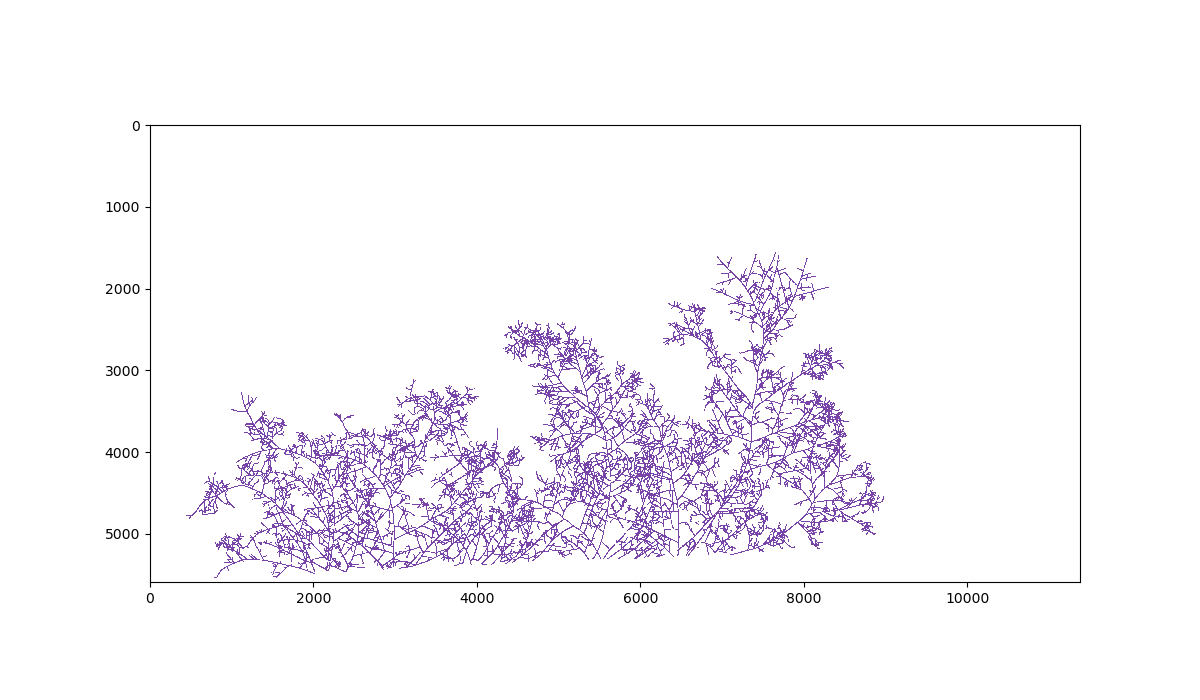

In [7]:
t=0

G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

vmax = 4
vmin = 0
downsizing = 5
edges_network = get_all_edges(exp,t)
region = [[3650*downsizing,5450*downsizing],[3900*downsizing,5700*downsizing]]
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge: 2,
    # lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    # plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 7),
    alpha = 1,
    # save_path = "figfull",
    dpi = 600,
    # label_colorbar = "Quantitative BC (um/s)",
    # region = region
    save_path = os.path.join("finalfigure","1", f"raw_network.png")
)
plt.savefig(
    os.path.join("finalfigure","1", f"raw_network.pdf"),
    transparent=True,
    bbox_inches="tight",
)

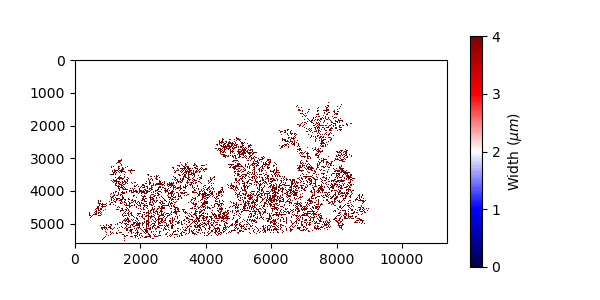

In [37]:
t=0

G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

vmax = 4
vmin = 0
downsizing = 5
edges_network = get_all_edges(exp,t)
t=1
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge: 4,
    plot_cmap=True,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    # plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(6, 3),
    alpha = 1,
    dpi = 600,

)
t = 0
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge: 0,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(6, 3),
    alpha = 1,
    dpi = 600,
    figax = (fig,ax),
    save_path = os.path.join("finalfigure","2", f"growth_network.png")
)



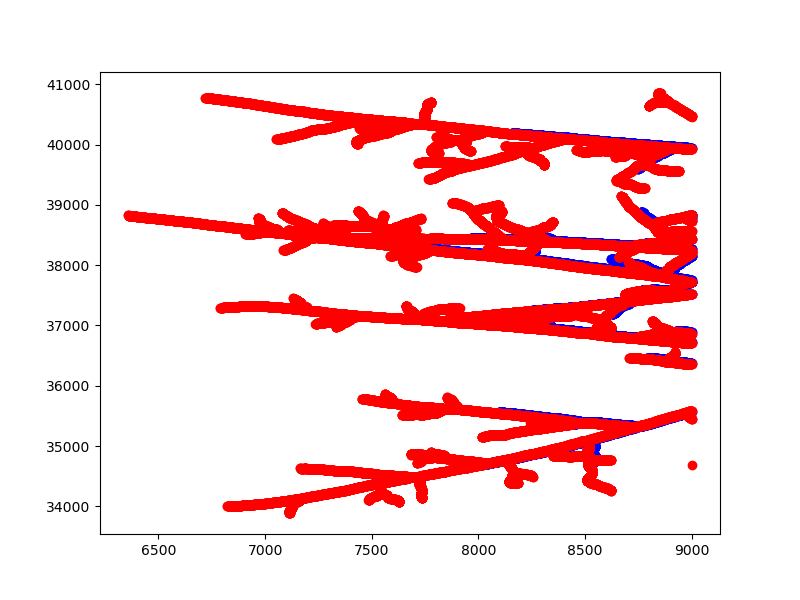

In [29]:
edges1 = get_all_edges(exp,0)
edges2 = get_all_edges(exp,1)
pixels1 = [pixel for edge in edges1 for pixel in edge.pixel_list(0)]
pixels2 = [pixel for edge in edges2 for pixel in edge.pixel_list(1)]
pixels1 = np.array(pixels1)
pixels2 = np.array(pixels2)
pixel_select1 = pixels1[np.where(pixels1[:,0]<=9000)]
pixel_select2 = pixels2[np.where(pixels2[:,0]<=9000)]

fig,ax = plt.subplots(figsize=(8, 6))

# Plot each array of coordinates in a different color
ax.scatter(pixel_select1[:, 0], pixel_select1[:, 1], color='blue', label='Array 1')  # Blue color for the first array
ax.scatter(pixel_select2[:, 0], pixel_select2[:, 1], color='red', label='Array 2')  # Red color for the second array


In [22]:
data = pd.read_excel(r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE_ANALYSIS\plate_summary2.xlsx")
data = data[data['crossed'].notna()]
data = data[data['fungus'].isin(['A5', 'Agg', 'B12', 'C2', 'A5sp3', 'Clarum', 'GC-10', 4350,
       'clarum', 'C5', '9A-1', 'O9',
       'd1', 'A5 Vasilis', 'A1', 'C3', 'A5V '])]

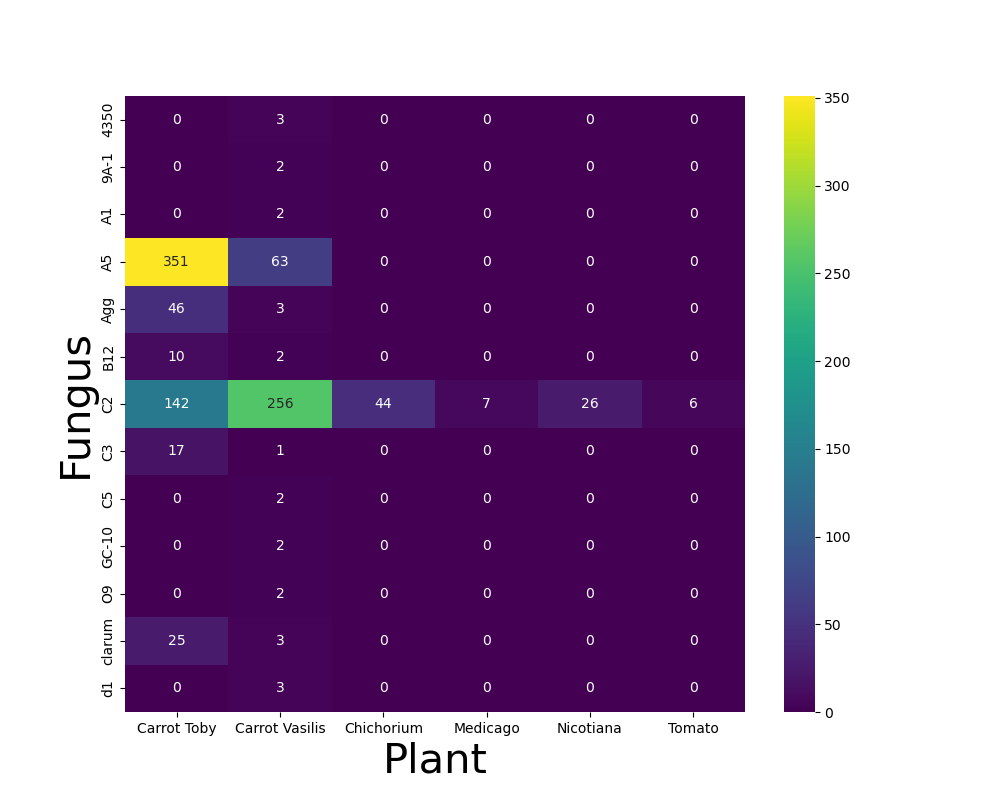

In [34]:
import seaborn as sns
df_sum = data
df_sum['real_root'] = df_sum['root']
df_sum.loc[df_sum['real_root'] == "EN daurus carota", 'real_root'] = "Carrot Vasilis"
df_sum.loc[df_sum['real_root'] == "EN", 'real_root'] = "Carrot Vasilis"

df_sum.loc[df_sum['real_root'] == "carrotV", 'real_root'] = "Carrot Vasilis"
df_sum.loc[df_sum['real_root'] == "CarrotEN", 'real_root'] = "Carrot Vasilis"
df_sum.loc[df_sum['real_root'] == "CarrotToby", 'real_root'] = "Carrot Toby"


df_sum.loc[df_sum['real_root'] == "Carrot", 'real_root'] = "Carrot Toby"

df_sum.loc[df_sum['real_root'] == "carrot", 'real_root'] = "Carrot Toby"
df_sum.loc[df_sum['real_root'] == "CH cichorium intybus", 'real_root'] = "Chichorium"
df_sum.loc[df_sum['real_root'] == "BE nicotiana benthamiana", 'real_root'] = "Nicotiana"
df_sum.loc[df_sum['fungus'] == "A5 Vasilis", 'fungus'] = "A5"
df_sum.loc[df_sum['fungus'] == "A5V", 'fungus'] = "A5"
df_sum.loc[df_sum['fungus'] == "A5V ", 'fungus'] = "A5"
df_sum.loc[df_sum['fungus'] == "A5sp3", 'fungus'] = "A5"
df_sum.loc[df_sum['fungus'] == "Clarum", 'fungus'] = "clarum"




df_sum['fungus'].unique()
count_matrix = df_sum.groupby(['fungus', 'real_root']).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(count_matrix, annot=True, cmap='viridis', fmt='d')  # 'd' for integer format
plt.ylabel('Fungus',size = 30)
plt.xlabel('Plant',size = 30)
plt.show()